# Analyzing COVID-19 Papers

In this challenge, we will continue with the topic of COVID pandemic, and focus on processing scientific papers on the subject. There is [CORD-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) with more than 7000 (at the time of writing) papers on COVID, available with metadata and abstracts (and for about half of them there is also full text provided).

A full example of analyzing this dataset using [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) cognitive service is described [in this blog post](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). We will discuss simplified version of this analysis.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Getting the Data

First, we need get the metadata for CORD papers that we will be working with.

**NOTE**: We do not provide a copy of the dataset as part of this repository. You may first need to download the [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) file from [this dataset on Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Registration with Kaggle may be required. You may also download the dataset without registration [from here](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), but it will include all full texts in addition to metadata file.

We will try to get the data directly from online source, however, if it fails, you need to download the data as described above. Also, it makes sense to download the data if you plan to experiment with it further, to save on waiting time.

> **NOTE** that dataset is quite large, around 1 Gb in size, and the following line of code can take a long time to complete! (~5 mins)

In [3]:
# df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
df = pd.read_csv("metadata.csv")
df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,4429oz9s,NaN,Medline,Will pay for performance improve quality of ca...,10.1056/nejme1212133,NaN,23134388.0,unk,NaN,2012,"Epstein, Arnold M",The New England journal of medicine,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.1056/nejme1212133; https://...,10014458.0
1,sjdy79ok,NaN,Medline; WHO,Impact of Sitagliptin in Non-Diabetic Covid-19...,10.2174/1874467214666210902115650,NaN,34477540.0,unk,OBJECTIVE In Coronavirus disease 2019 (Covid-1...,2021-09-01,"Al-Kuraishy, Hayder M; Al-Gareeb, Ali I; Qusty...",Current molecular pharmacology,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.2174/1874467214666210902115...,237399283.0
2,qa5n3xpi,NaN,WHO,Utilizing Health Behavior Change and Technolog...,NaN,NaN,NaN,unk,BACKGROUND: To combat the global COVID-19 pand...,2021,"Tomczyk, Samuel; Barth, Simon; Schmidt, Silke;...",J Med Internet Res,NaN,#covidwho-1259297,NaN,NaN,NaN,NaN,233351148.0
3,jasf7agm,4d4a64f98aac069dd375c8a82d84808fcd7493d8,Medline; PMC,Tiotropium bromide as adjunct therapy in child...,10.1186/s13223-021-00632-4,PMC8666101,34895321.0,cc-by,BACKGROUND: The Global Initiative for Asthma h...,2021-12-12,"Ridha, Zainab; Bédard, Marc-Antoine; Smyrnova,...",Allergy Asthma Clin Immunol,NaN,NaN,NaN,document_parses/pdf_json/4d4a64f98aac069dd375c...,document_parses/pmc_json/PMC8666101.xml.json,https://doi.org/10.1186/s13223-021-00632-4; ht...,245118970.0
4,dagq84tr,464b915e6d545b37d65ac58cecf42512b11a92e2,Medline; PMC; WHO,"Anti-inflammatory adipokines: chemerin, vaspin...",10.1038/s41598-021-00928-w,PMC8563971,34728695.0,cc-by,Coronavirus disease 2019 (COVID-19) is associa...,2021-11-02,"Kukla, Michał; Menżyk, Tomasz; Dembiński, Marc...",Sci Rep,NaN,NaN,NaN,document_parses/pdf_json/464b915e6d545b37d65ac...,document_parses/pmc_json/PMC8563971.xml.json,https://doi.org/10.1038/s41598-021-00928-w; ht...,241112264.0


We will now convert publication date column to `datetime`, and plot the histogram to see the range of publication dates.

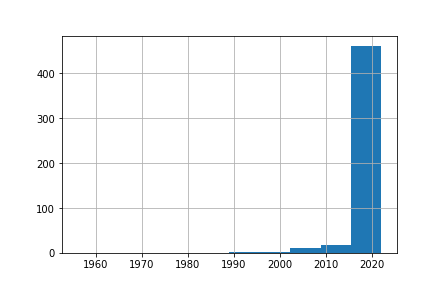

In [111]:
df['publish_time'] = pd.to_datetime(df['publish_time'],format='%Y%m%d')#errors='coerce')
df['publish_time'].hist()
plt.show()

Interestingly, there are coronavirus-related papers that date back to 1880!

## Structured Data Extraction

Let's see what kind of information we can easily extract from abstracts. One thing we might be interested in is to see which treatment strategies exist, and how they evolved over time. To begin with, we can manually compile the list of possible medications used to treat COVID, and also the list of diagnoses. We then go over them and search corresponding terms in the abstracts of papers.

In [112]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]
#medications = [ 'lopinavir', 'remdesivir', 'favipiravir', 'alpha-interferon','azithromycin', 'ribavirin', 'atazanavir', 'umifenovir']

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


We have added a bunch of columns to our dataframe that contain number of times a given medicine/diagnosis is present in the abstract. 

> **Note** that we add space to the beginning of the word when looking for a substring. If we do not do that, we might get wrong results, because *chloroquine* would also be found inside substring *hydroxychloroquine*. Also, we force conversion of abstracts column to `str` to get rid of an error - try removing `str` and see what happens.

To make working with data easier, we can extract the sub-frame with only medication counts, and compute the accumulated number of occurrences. This gives is the most popular medication: 

In [113]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

,Name,Count
3,remdesivir,12
7,dexamethasone,12
0,hydroxychloroquine,7
4,azithromycin,6
1,chloroquine,3
2,tocilizumab,2
5,lopinavir,1
8,heparin,1
9,favipiravir,1
6,ritonavir,0


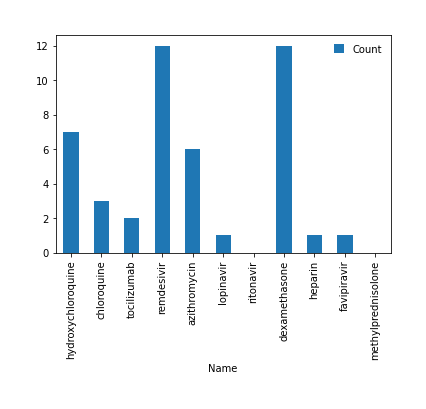

In [114]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Looking for Trends in Treatment Strategy

In the example above we have `sum`ed all values, but we can also do the same on a monthly basis:

In [116]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2019-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

,,hydroxychloroquine,chloroquine,tocilizumab,remdesivir,azithromycin,lopinavir,ritonavir,dexamethasone,heparin,favipiravir,methylprednisolone
publish_time,publish_time,,,,,,,,,,,
2019,1,0,0,0,0,0,0,0,0,0,0,0
2020,1,1,0,0,0,0,0,0,0,0,0,0
2021,1,2,0,0,3,0,0,0,0,0,0,0


This gives us a good picture of treatment strategies. Let's visualize it!

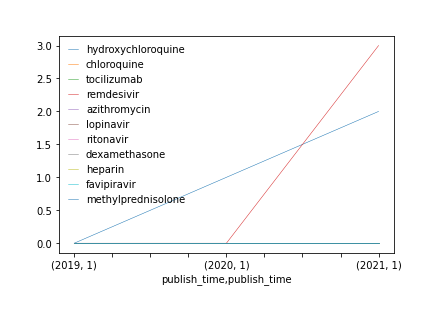

In [117]:
dfmt.plot()
plt.show()

An interesting observation is that we have huge spikes at two locations: January, 2020 and January, 2021. It is caused by the fact that some papers do not have a clearly specified data of publication, and they are specified as January of the respective year.

To make more sense of the data, let's visualize just a few medicines. We will also "erase" data for January, and fill it in by some medium value, in order to make nicer plot:

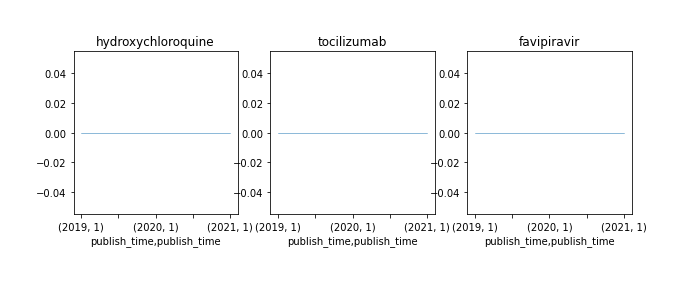

In [119]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
#['lopinavir', 'remdesivir', 'favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

Observe how popularity of hydroxychloroquine was on the rise in the first few months, and then started to decline, while number of mentions of favipiravir shows stable rise. Another good way to visualize relative popularity is to use **stack plot** (or **area plot** in Pandas terminology):

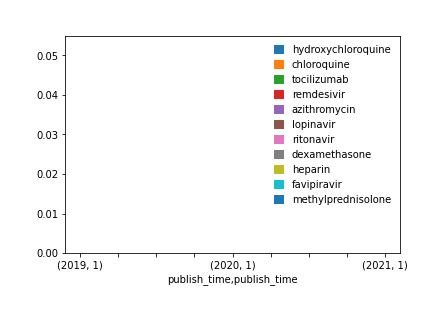

In [129]:
dfmt.plot.area()
plt.show()

Even further, we can compute relative popularity in percents:

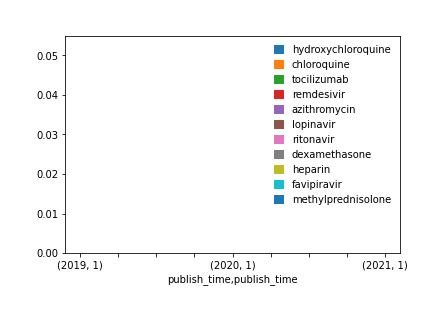

In [121]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()


## Computing Medicine-Diagnosis Correspondence

One of the most interesting relationships we can look for is how different diagnoses are treated with different medicines. In order to visualize it, we need to compute **co-occurence frequency map**, which would show how many times two terms are mentioned in the same paper.

Such a map is essentially a 2D matrix, which is best represented by **numpy array**. We will compute this map by walking through all abstracts, and marking entities that occur there:

In [122]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [123]:
m

array([[4., 3., 1., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [2., 2., 1., 2., 0., 1., 0.],
       [2., 1., 1., 0., 0., 0., 1.],
       [1., 1., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 1., 1., 0., 1.],
       [1., 1., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

One of the ways to visualize this matrix is to draw a **heatmap**:

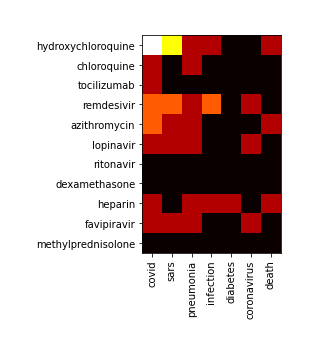

In [124]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

However, even better visualization can be done using so-called **Sankey** diagram! `matplotlib` does not have built-in support for this diagram type, so we would have to use [Plotly](https://plotly.com/python/) as described [in this tutorial](https://plotly.com/python/sankey-diagram/).

To make plotly sankey diagram, we need to build the following lists:
* List `all_nodes` of all nodes in the graph, which will include both medications and diagnosis
* List of source and target indices - those lists would show, which nodes go to the left, and which to the right part of the diagram
* List of all links, each link consisting of:
   - Source index in the `all_nodes` array
   - Target index 
   - Value indicating strength of the link. This is exactly the value from our co-occurence matrix.
   - Optionally color of the link. We will make an option to highlight some of the terms for clarity

Generic code to draw sankey diagram is structured as a separate `sankey` function, which takes two lists (source and target categories) and co-occurence matrix. It also allows us to specify the threshold, and omit all links that are weaker than that threshold - this makes the diagram a little bit less complex. 

In [125]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Conclusion

You have seen that we can use quite simple methods to extract information from non-structured data sources, such as text. In this example, we have taken the existing list of medications, but it would be much more powerful to use natural language processing (NLP) techniques to perform entity extraction from text. In [this blog post](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) we describe how to use cloud services for entity extraction. Another option would be using Python NLP libraries such as [NLTK](https://www.nltk.org/) - an approach for extracting information from text using NLTK is described [here](https://www.nltk.org/book/ch07.html).

## Challenge

Continue to research the COVID paper data along the following lines:

1. Build co-occurrence matrix of different medications, and see which medications often occur together (i.e. mentioned in one abstract). You can modify the code for building co-occurrence matrix for medications and diagnoses.
1. Visualize this matrix using heatmap.
1. As a stretch goal, you may want to visualize the co-occurrence of medications using [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram). [This library](https://pypi.org/project/chord/) may help you draw a chord diagram.
1. As another stretch goal, try to extract dosages of different medications (such as **400mg** in *take 400mg of chloroquine daily*) using regular expressions, and build dataframe that shows different dosages for different medications. **Note**: consider numeric values that are in close textual vicinity of the medicine name.

- *Build co-occurrence matrix of different medications, and see which medications often occur together (i.e. mentioned in one abstract). You can modify the code for building co-occurrence matrix for medications and diagnoses.*

In [130]:
medications = [ 'lopinavir', 'remdesivir', 'favipiravir', 'azithromycin', 'ribavirin', 'atazanavir', 'umifenovir']
#medications = [ 'lopinavir', 'ritonavir', 'remdesivir', 'favipiravir', 'alpha-interferon', 'ribavirin', 'atazanavir', 'umifenovir', 'tocilizumab']
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1
            
m

array([[1., 1., 1., 0., 0., 1., 0.],
       [2., 2., 1., 2., 0., 1., 0.],
       [1., 1., 1., 0., 0., 1., 0.],
       [2., 1., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 1., 0.]])

- *Visualize this matrix using heatmap.*


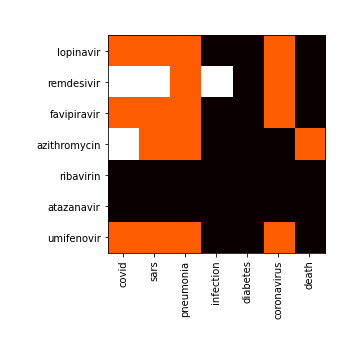

In [132]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

from mpl_chord_diagram import chord_diagram
chord_diagram(m,names=medications)

- *As a stretch goal, you may want to visualize the co-occurrence of medications using chord diagram. This library may help you draw a chord diagram.*


[(0.9298336239085414, 0.487759604568797, -62.32),
 (-0.4055394476172479, 0.9685234929656057, 22.72),
 (-0.9999597050938244, -0.3202820447491115, -72.24000000000001),
 (-0.14540581604798394, -1.039883237993295, -7.960000000000036),
 (0.5032699234336461, -0.9215310001118204, 28.639999999999986),
 (0.5351243130938432, -0.9034057612921464, 30.639999999999986),
 (0.9122446296768576, -0.5199132000879887, 60.31999999999999)]

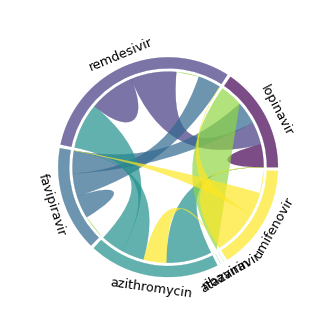

In [127]:
from mpl_chord_diagram import chord_diagram
chord_diagram(m,names=medications)

[(0.9040815350429029, 0.5339818142918995, -59.432432432432435),
 (-0.04629517634661684, 1.0489789114405665, 2.5270270270270316),
 (-0.9381289594318638, 0.4716079467897975, 63.31081081081081),
 (-0.9040815350429026, -0.5339818142918997, -59.43243243243242),
 (0.0032194198596715486, -1.0499950644340035, 0.17567567567573406),
 (0.9179902761408675, -0.5096997674227582, 60.95945945945948)]

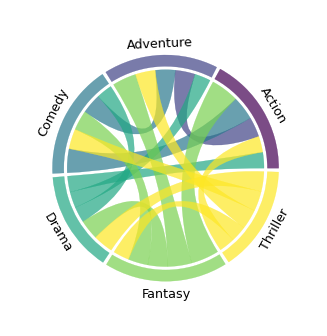

In [61]:
matrix = [
    [0, 5, 6, 4, 7, 4],
    [5, 0, 5, 4, 6, 5],
    [6, 5, 0, 4, 5, 5],
    [4, 4, 4, 0, 5, 5],
    [7, 6, 5, 5, 0, 4],
    [4, 5, 5, 5, 4, 0],
]

names = ["Action", "Adventure", "Comedy", "Drama", "Fantasy", "Thriller"]
matrix
chord_diagram(matrix,names=names)